# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm/ttm-research-r2)

## Install `tsfm` 
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.14"

## Imports

In [1]:
import math
import os
import tempfile

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TrackingCallback, count_parameters, load_dataset
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

2024-11-04 10:42:59.846438: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 10:42:59.884441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 10:43:01.679490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [3]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Dataset
# The dataloaders will utilize the easy-to-use YAML configurations defined below.
# Dataset configuration YAMLS: https://github.com/ibm-granite/granite-tsfm/tree/main/tsfm_public/resources/data_config
# Note that `dataset_root_path` can also be provided instead of `dataset_path` to the `load_dataset()` function to
# run this notebook on already downloaded dataset.
# Check the `load_dataset()` function to see more functionalities.
TARGET_DATASET = "etth1"
DATASET_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

## Zero-shot evaluation method

In [4]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data
    _, _, dset_test = load_dataset(
        dataset_name=dataset_name,
        context_length=context_length,
        forecast_length=forecast_length,
        fewshot_fraction=1.0,
        dataset_path=DATASET_PATH,
    )

    # Load model
    zeroshot_model = get_model(TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length)

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

 ## Few-shot finetune and evaluation method

In [5]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    dset_train, dset_val, dset_test = load_dataset(
        dataset_name,
        context_length,
        forecast_length,
        fewshot_fraction=fewshot_percent / 100,
        dataset_path=DATASET_PATH,
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length, head_dropout=0.7
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length
        )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

## Example: downstream target dataset - etth1

### Zero-shot

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.3628121316432953, 'eval_model_preparation_time': 0.0019, 'eval_runtime': 0.9077, 'eval_samples_per_second': 3068.323, 'eval_steps_per_second': 48.476}


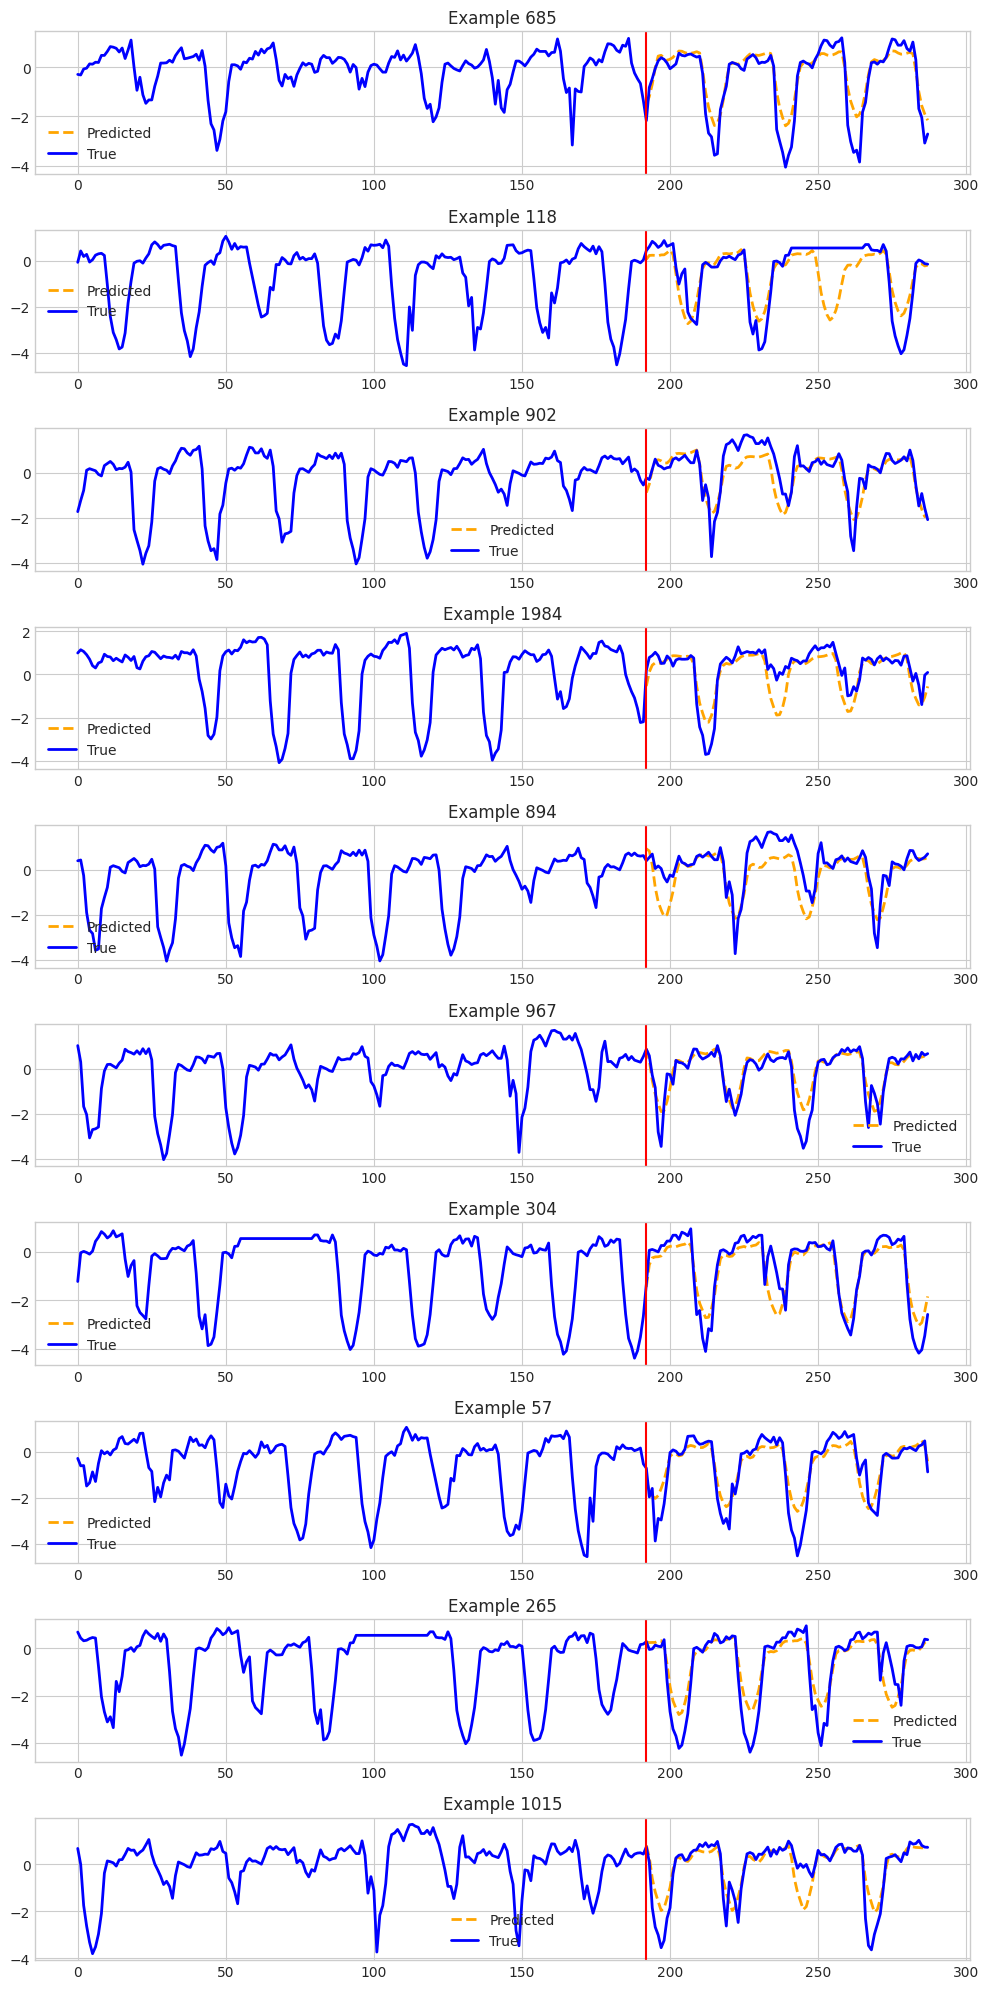

In [6]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=96, batch_size=64)

### Few-shot 5%

-------------------- Running few-shot 5% --------------------


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.806300,0.664025
2,0.809300,0.663463
3,0.759700,0.662726
4,0.712000,0.662024
5,0.720700,0.662027
6,0.684800,0.664132
7,0.669900,0.669062
8,0.630200,0.677566
9,0.624800,0.685926
10,0.597700,0.696449


[TrackingCallback] Mean Epoch Time = 0.4760245255061558 seconds, Total Train Time = 16.35079002380371
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.36187952756881714, 'eval_runtime': 0.6159, 'eval_samples_per_second': 4522.198, 'eval_steps_per_second': 71.446, 'epoch': 14.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


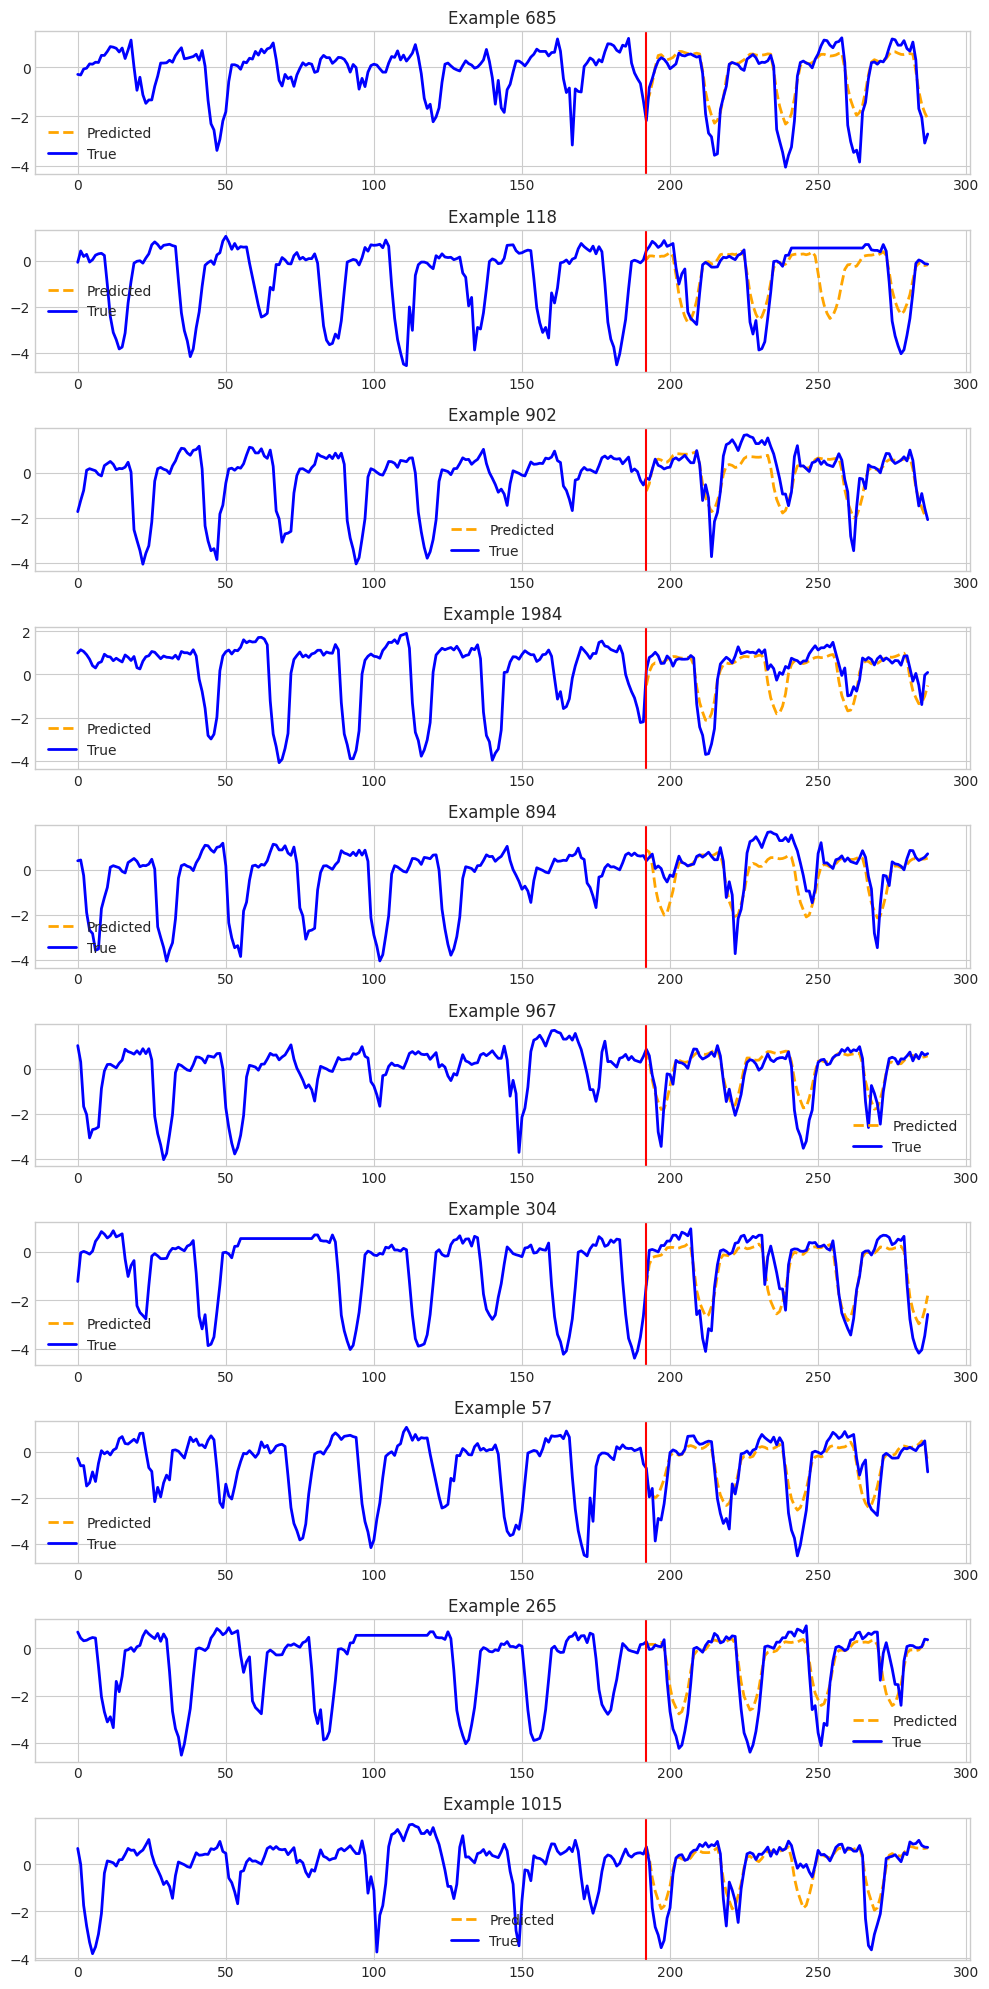

In [7]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=96,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

## Example: TTM for other forecast horizon lengths

Here, we demonstrate that a pre-trained 512-96 TTM model (i.e., context length = 512, forecast horizon = 96) 
can be used for a task having forecast horizon less than 96 time points.

Note that the model performance might be sacrificed by some margin while truncating the model forecast. It is recommended to try 
this feature in your validation data for your experiment, to verify if the model performance is in the acceptable threshold. 
Otherwise, a new TTM model can be pre-trained with the required forecast horizon.

In this example, we will use a 512-96 TTM and use it on etth1 data for forecasting 48 points in both zero-shot and 5% few-shot settings.

### Zero-shot

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.34208083152770996, 'eval_model_preparation_time': 0.0021, 'eval_runtime': 0.6053, 'eval_samples_per_second': 4680.197, 'eval_steps_per_second': 74.341}


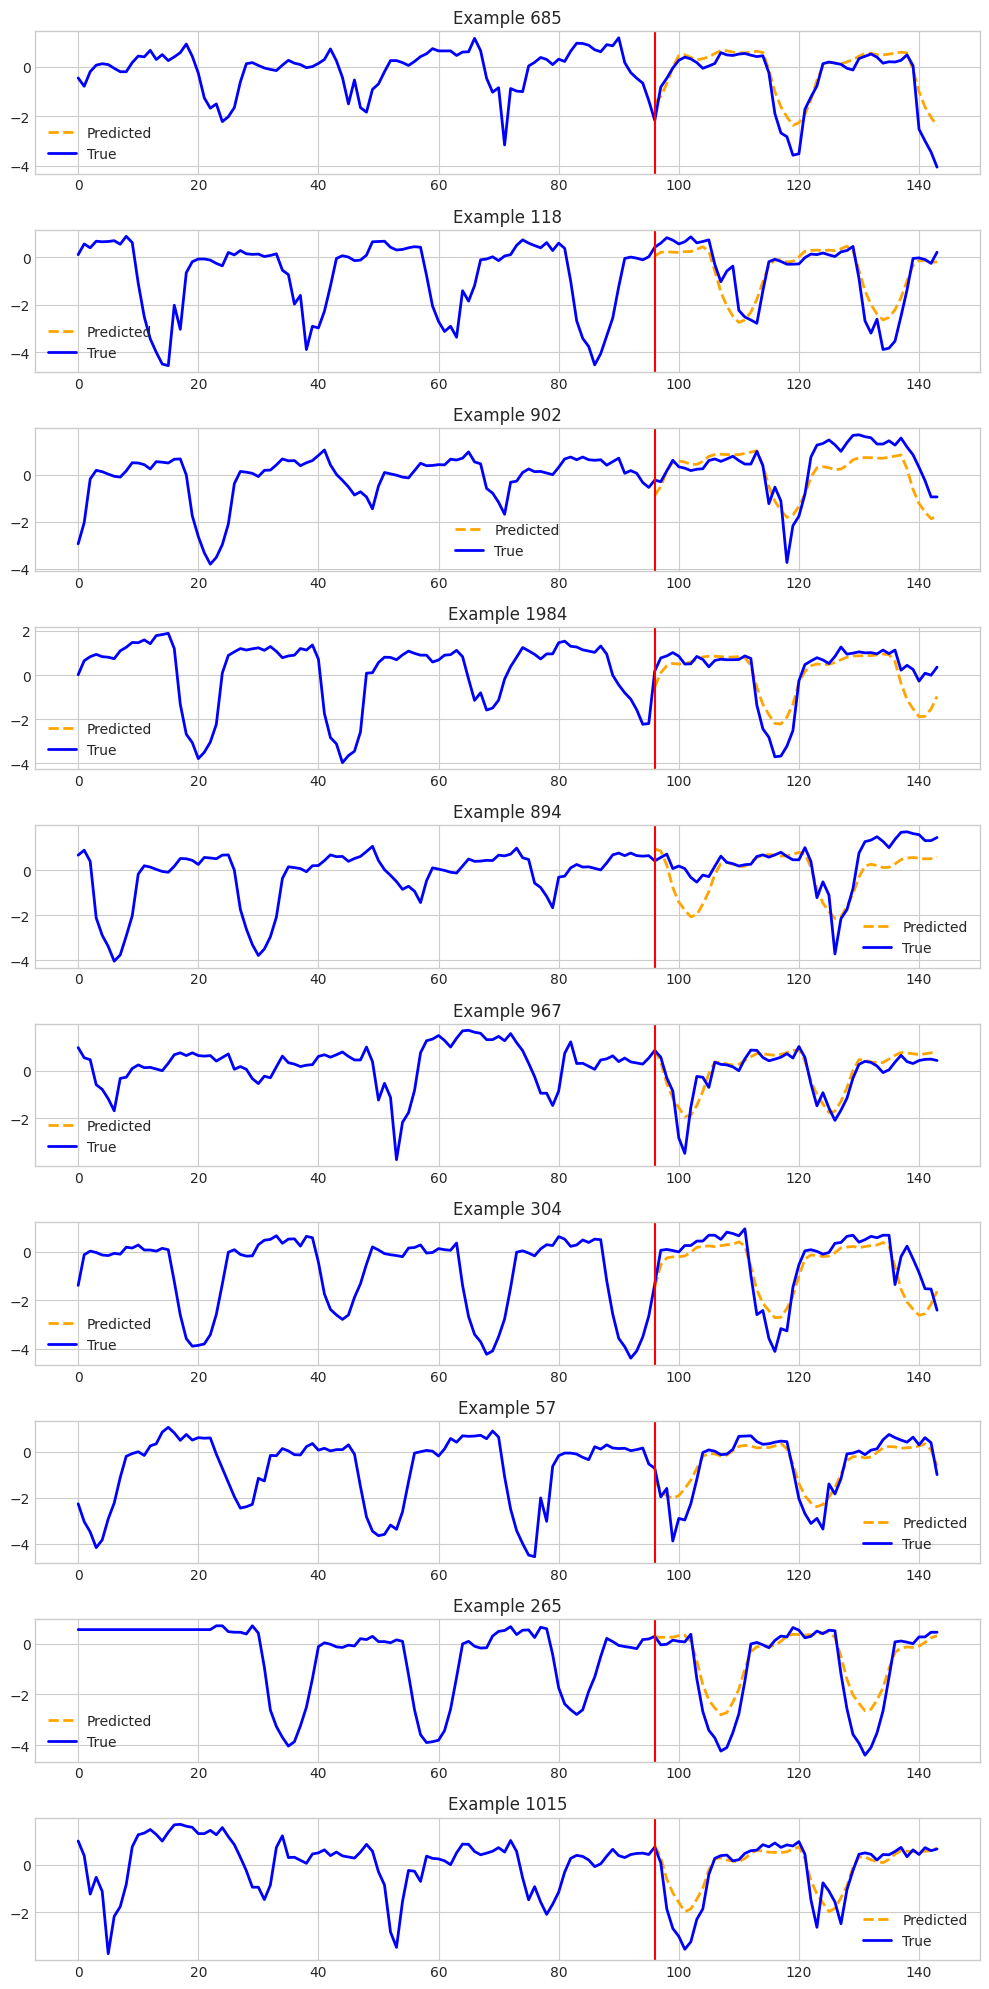

In [8]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=48, batch_size=64)

### Few-shot 5%

-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


OPTIMAL SUGGESTED LEARNING RATE = 0.0013219411484660286
Using learning rate = 0.0013219411484660286


Epoch,Training Loss,Validation Loss
1,0.662900,0.499343
2,0.643700,0.499057
3,0.621700,0.499072
4,0.571700,0.499452
5,0.546600,0.501533
6,0.515600,0.507285
7,0.476700,0.519022
8,0.462500,0.529781
9,0.451200,0.542904
10,0.426500,0.549049


[TrackingCallback] Mean Epoch Time = 0.4244766632715861 seconds, Total Train Time = 13.371108055114746
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.3415098488330841, 'eval_runtime': 0.6066, 'eval_samples_per_second': 4670.135, 'eval_steps_per_second': 74.181, 'epoch': 12.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


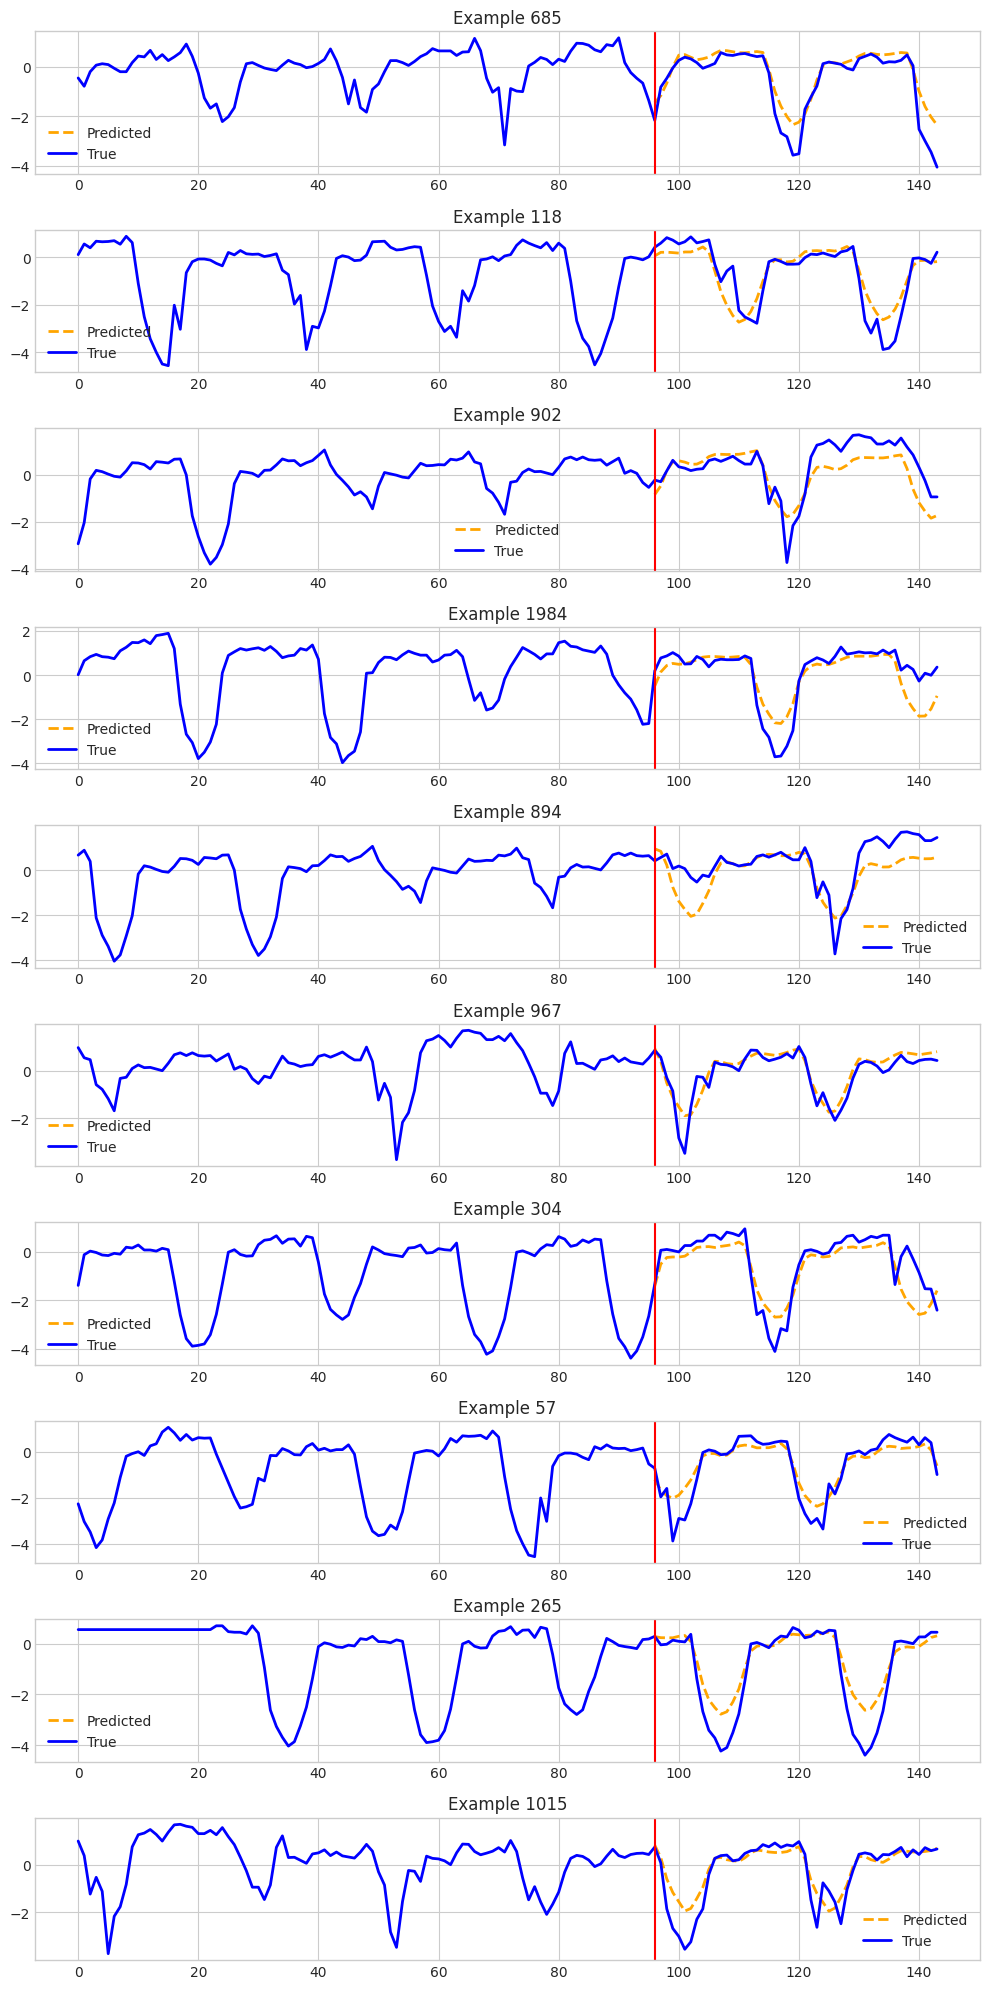

In [9]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=48,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
)